In [1]:
import pandas as pd
import numpy as np

# Load the preprocessed data
modelling_table = pd.read_csv("analyzed_data_sep.csv")

modelling_table['valid_datetime'] = pd.to_datetime(modelling_table['valid_datetime'])
modelling_table['ref_datetime'] = pd.to_datetime(modelling_table['ref_datetime'])

# Define the Pinball function
def pinball(y, q, alpha):
    return round((y - q) * alpha * (y >= q) + (q - y) * (1 - alpha) * (y < q),2)

# Calculate the Pinball Score
def pinball_score(df):
    score = list()
    for qu in range(10, 100, 10):
        pinball_loss = pinball(y=df["total_generation_MWh"], q=df[f"q{qu}"], alpha=qu/100).mean()
        rounded_loss = round(pinball_loss, 2)
        score.append(rounded_loss)
        print(f"pinball loss for q{qu} = {rounded_loss:.2f}")  # Use formatted string with .2f
    return round(sum(score)/len(score), 2)

# Calculate and print the Pinball Score
score = pinball_score(modelling_table)
print(f"pinball loss = {score:.2f}")  # Use formatted string with .2f

pinball loss for q10 = 18.00
pinball loss for q20 = 26.49
pinball loss for q30 = 31.61
pinball loss for q40 = 34.40
pinball loss for q50 = 35.16
pinball loss for q60 = 34.01
pinball loss for q70 = 30.90
pinball loss for q80 = 25.49
pinball loss for q90 = 16.87
pinball loss = 28.10


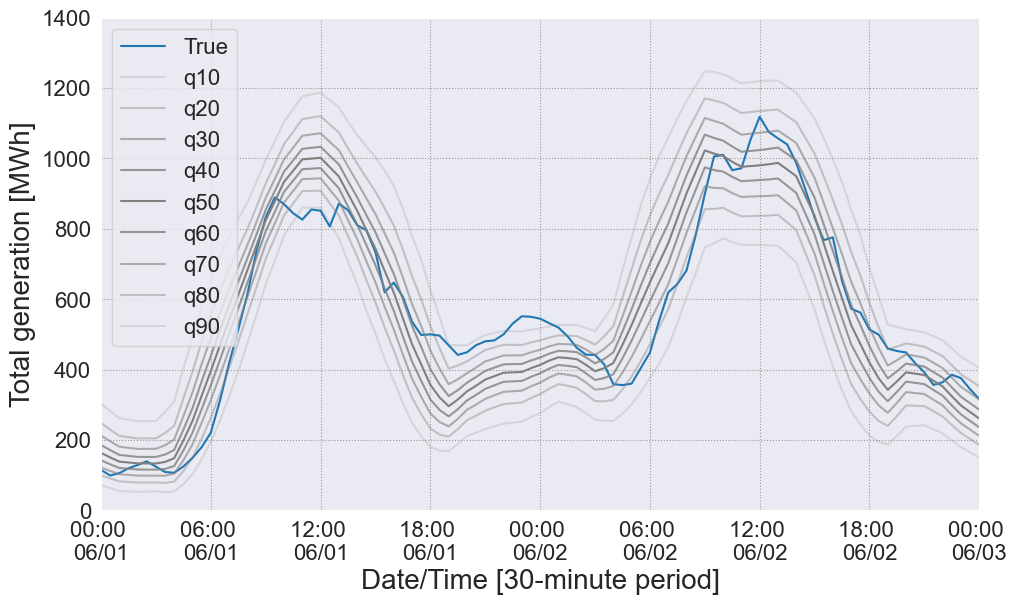

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# 特定のref_datetimeに一致する行を抽出
ref_datetime = pd.to_datetime("2021-6-1 00:00:00+0000")
filtered_data = modelling_table[modelling_table['ref_datetime'] == ref_datetime]

plt.figure(figsize=(10, 6))
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
ax1 = sns.lineplot(data=filtered_data, x="valid_datetime", y="total_generation_MWh", label="True")

for quantile in range(10, 100, 10):
    sns.lineplot(data=modelling_table,
                 x=filtered_data["valid_datetime"],
                 y=filtered_data[f"q{quantile}"],
                 color='gray',
                 alpha=1 - abs(50 - quantile) / 50,
                 label=f'q{quantile}')

plt.ylim(0, 1400)
plt.xlim(filtered_data['valid_datetime'].min(), filtered_data['valid_datetime'].max())
#plt.xticks(modelling_table['valid_datetime'][::6])
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M \n%m/%d"))
plt.xlabel('Date/Time [30-minute period]', fontsize=20)
plt.ylabel('Total generation [MWh]', fontsize=20)
#plt.title(f"Forecast reference time: {filtered_data['ref_datetime'].iloc[0]}", fontsize=14)
plt.tight_layout()
ax1.legend(fontsize=16)
plt.tick_params(axis='both', labelsize=16)

plt.show()

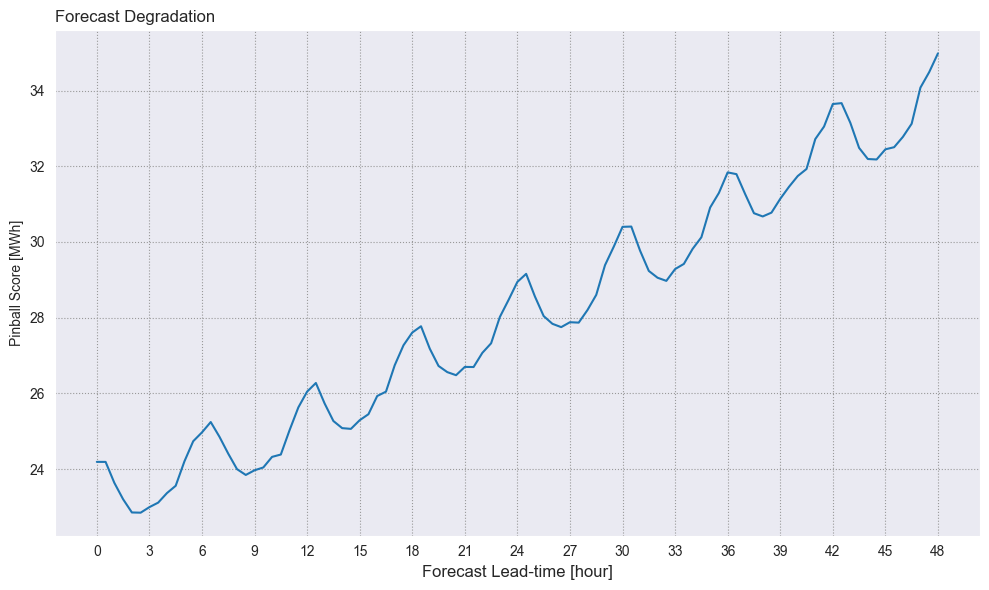

In [10]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

modelling_table['lead_time'] = modelling_table['valid_datetime'] - modelling_table['ref_datetime']

forecast_performance = modelling_table.groupby('lead_time').apply(pinball_score)
forecast_performance = modelling_table.groupby('lead_time').apply(pinball_score)
forecast_performance.index = forecast_performance.index.total_seconds() / (3600)

plt.figure(figsize=(10, 6))
ax1 = forecast_performance.plot()
ax1.set_ylabel('Pinball Score [MWh]')
ax1.set_xlabel('Forecast Lead-time [hour]', fontsize=12)

# x軸の刻みを変更
ax1.xaxis.set_major_locator(ticker.MultipleLocator(base=3))  # 6は3時間ごとに調整したい場合

ax1.set_title('Forecast Degradation', loc='left')
plt.tight_layout()

In [8]:
modelling_table[["valid_datetime","q10","q20","q30","q40","q50","q60","q70","q80","q90","total_generation_MWh"]]

,valid_datetime,q10,q20,q30,q40,q50,q60,q70,q80,q90,total_generation_MWh
0,2020-09-20 00:00:00+00:00,324.31,404.95,448.16,475.58,496.50,514.24,530.79,547.02,565.93,498.142
1,2020-09-20 00:30:00+00:00,327.82,408.20,451.46,478.89,499.74,517.16,533.36,549.20,567.39,478.788
2,2020-09-20 01:00:00+00:00,330.97,410.59,453.68,481.04,501.80,518.95,534.88,550.50,568.24,470.522
3,2020-09-20 01:30:00+00:00,327.80,406.71,449.77,477.33,498.40,515.80,532.07,548.23,566.69,482.183
4,2020-09-20 02:00:00+00:00,324.64,402.61,445.52,473.24,494.60,512.26,528.90,545.65,564.92,459.216
...,...,...,...,...,...,...,...,...,...,...,...
435474,2023-10-22 22:30:00+00:00,3.49,12.05,20.04,28.02,36.56,46.06,57.10,72.51,100.38,2.692
435475,2023-10-22 22:30:00+00:00,3.15,8.53,14.09,20.27,27.18,35.18,44.68,57.92,82.84,2.692
435476,2023-10-22 22:30:00+00:00,7.76,18.13,27.02,35.46,44.10,53.55,64.82,80.10,108.91,2.692
435477,2023-10-22 22:30:00+00:00,4.27,11.55,18.56,25.86,33.72,42.59,53.03,67.42,94.19,2.692
